In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [22]:
data_mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = data_mnist.data
y_mnist = data_mnist.target



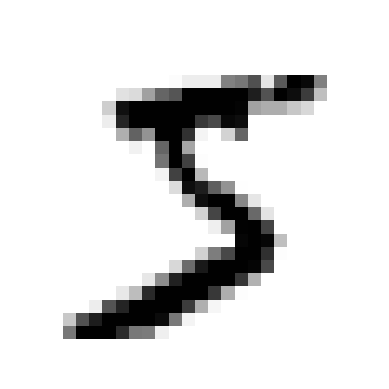

Label: 5


In [23]:
import matplotlib.pyplot as plt

def show_number(index):
    some_digit = X_mnist[index].reshape(28, 28)
    plt.imshow(some_digit, cmap=plt.cm.binary)
    plt.axis("off")
    plt.show()
    print("Label:", y_mnist[index])

show_number(0)

In [24]:
X_train, X_valid, X_test = X_mnist[:50000], X_mnist[50000:60000], X_mnist[60000:]
y_train, y_valid, y_test = y_mnist[:50000], y_mnist[50000:60000], y_mnist[60000:]

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train_scaled)

In [26]:
sgd_clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
dec_tree_clf = DecisionTreeClassifier(max_depth=20, random_state=42)
rnd_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [27]:
estimators= [sgd_clf, dec_tree_clf, rnd_forest_clf]
for i in estimators:
    print(f"Training {i.__class__.__name__}...")
    i.fit(X_train, y_train)

Training SGDClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...


In [28]:
[i.score(X_valid, y_valid) for i in estimators]

[0.8739, 0.883, 0.9718]

In [30]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ('sgd_clf', sgd_clf),
    ('decision_tree', dec_tree_clf),
    ('random_forest', rnd_forest_clf)
]
voting_clf = VotingClassifier(estimators=named_estimators, voting='hard')
voting_clf.fit(X_train, y_train)
voting_clf.score(X_valid, y_valid)

0.9531

In [31]:
y_valid_encoded = y_valid.astype(np.int64)
[i.score(X_valid, y_valid_encoded) for i in voting_clf.estimators_]

[0.8739, 0.883, 0.9718]

Some Experiments

In [15]:
# Use LOgRegression RandomForest and 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,  HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline


log_reg_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=0.1, max_iter=2000, n_jobs=-1, random_state=42))
])
grd_boost_clf =  HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

In [16]:
estimators_v2 = [log_reg_clf, rnd_forest_clf, grd_boost_clf]

for i in estimators_v2:
    print(f"Training {i.__class__.__name__}...")
    i.fit(X_train, y_train)

Training Pipeline...
Training RandomForestClassifier...
Training HistGradientBoostingClassifier...


In [17]:
[i.score(X_valid, y_valid) for i in estimators_v2]

[0.928, 0.9718, 0.9594]

In [18]:
named_estimators_v2 = [
    ('log_reg_clf', log_reg_clf),
    ('random_forest', rnd_forest_clf),
    ('grd_boost_clf', grd_boost_clf)
]
voting_clf_v2 = VotingClassifier(estimators=named_estimators_v2, voting='soft')
voting_clf_v2.fit(X_train, y_train)
voting_clf_v2.score(X_valid, y_valid)

0.9602

In [20]:
from sklearn.metrics import confusion_matrix

y_valid_pred = voting_clf_v2.predict(X_valid)
conf_mx = confusion_matrix(y_valid, y_valid_pred)
print(conf_mx)

[[ 975    0    3    1    2    0    3    3    4    0]
 [   0 1052    4    1    1    0    1    2    3    0]
 [   3    3  943    6    8    2    4   11    8    2]
 [   2    1    7  975    1   20    1    2   13    8]
 [   0    8    0    1  951    1    3    2    2   15]
 [   8    1    8   20    4  848   16    4    5    1]
 [   2    0    2    0    5    3  952    0    3    0]
 [   1    4    8    2    2    1    0 1059    1   12]
 [   2    7    6    6    1   16    3    6  949   13]
 [   6    5    2   11   14    5    1   16    3  898]]


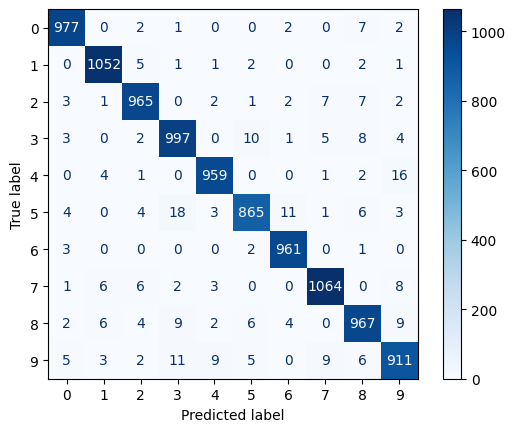

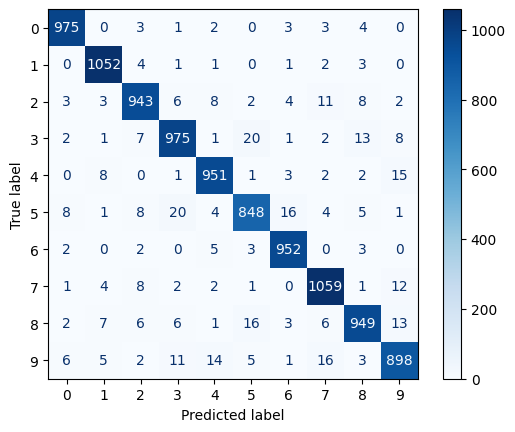

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

# Для RandomForest
ConfusionMatrixDisplay.from_estimator(rnd_forest_clf, X_valid, y_valid, cmap='Blues')

# Для ансамбля
ConfusionMatrixDisplay.from_estimator(voting_clf_v2, X_valid, y_valid, cmap='Blues')


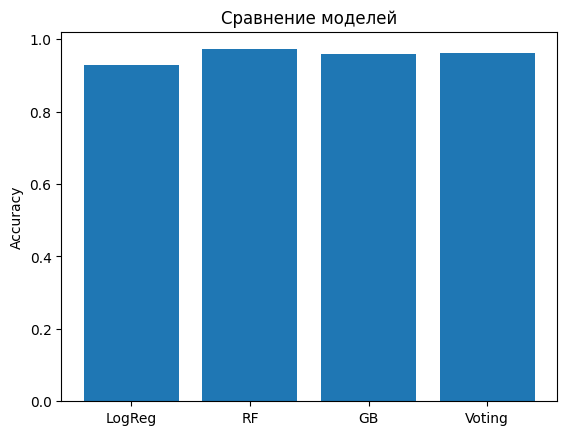

In [37]:
X_valid_scaled = scaler.transform(X_valid)

scores = [log_reg_clf.score(X_valid, y_valid),
          rnd_forest_clf.score(X_valid, y_valid),
          grd_boost_clf.score(X_valid, y_valid),
          voting_clf_v2.score(X_valid, y_valid)]

labels = ['LogReg', 'RF', 'GB', 'Voting']
plt.bar(labels, scores)
plt.ylabel('Accuracy')
plt.title('Сравнение моделей')
plt.show()


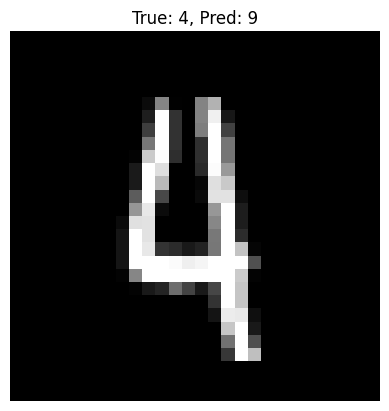

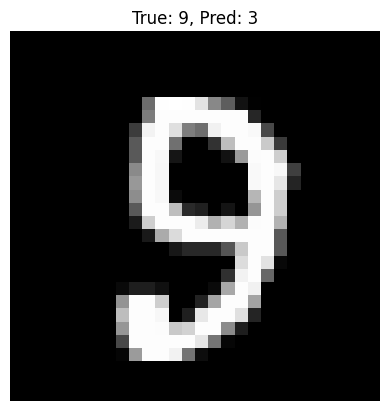

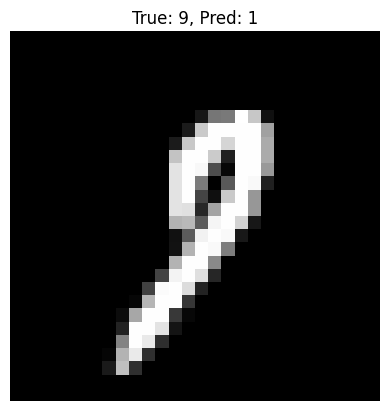

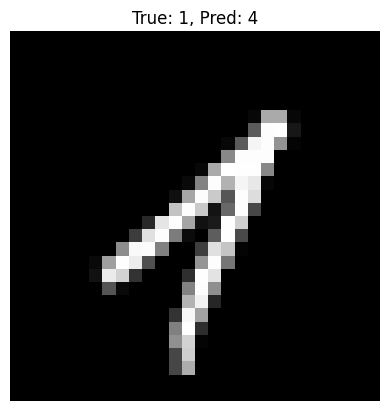

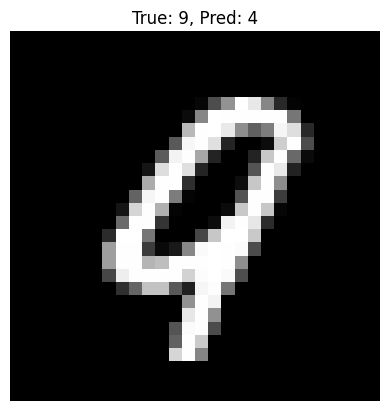

In [38]:
misclassified_idx = np.where(y_valid != y_valid_pred)[0]

for idx in misclassified_idx[:5]:
    plt.imshow(X_valid[idx].reshape(28,28), cmap='gray')
    plt.title(f"True: {y_valid[idx]}, Pred: {y_valid_pred[idx]}")
    plt.axis('off')
    plt.show()


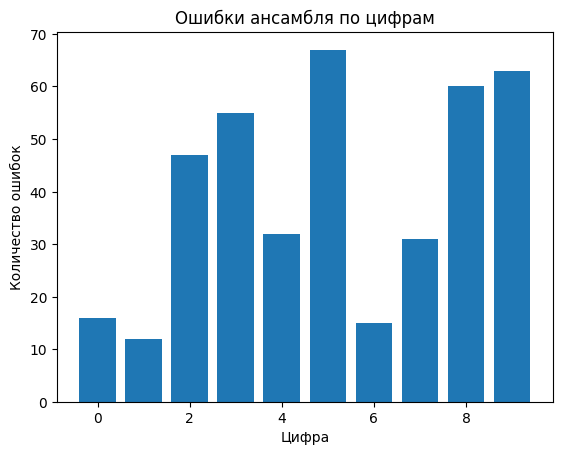

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Преобразуем к int
y_valid_int = y_valid.astype(int)
y_valid_pred_int = y_valid_pred.astype(int)

# Находим ошибки
errors = y_valid_int != y_valid_pred_int

# Считаем ошибки по цифрам
counts = np.bincount(y_valid_int[errors], minlength=10)

# Рисуем график
plt.bar(range(10), counts)
plt.xlabel('Цифра')
plt.ylabel('Количество ошибок')
plt.title('Ошибки ансамбля по цифрам')
plt.show()


In [ ]:
dffs